<a href="https://colab.research.google.com/github/rogerioferreira/MVP-Machine_Learnin-PUC-RIO/blob/main/notebooks/ml-03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [110]:
# Bibliotecas necessárias
import os
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split  # separação em treino e teste (holdout)
from sklearn.model_selection import KFold  # preparação dos folds da validação cruzada
from sklearn.model_selection import cross_val_score  # execução da validação cruzada
from sklearn.metrics import accuracy_score  # exibição da acurácia do modelo

from sklearn.neighbors import KNeighborsClassifier  # algoritmo KNN
from sklearn.tree import DecisionTreeClassifier  # algoritmo de Árvore de Decisão
from sklearn.naive_bayes import GaussianNB  # algoritmo Naive Bayes
from sklearn.svm import SVC  # algoritmo SVM

from sklearn.ensemble import AdaBoostClassifier  # algoritmo Ada Boost
from sklearn.ensemble import RandomForestClassifier  # algoritmo Randon Forest
from sklearn.ensemble import ExtraTreesClassifier  # algoritmo Extra Trees


# Configuração para não exibir os warnings
warnings.filterwarnings("ignore")

In [111]:
# Fonte: https://www.kaggle.com/datasets/iammustafatz/diabetes-prediction-dataset


data_path = "../dados/diabetes_prediction_dataset.csv"
url = "https://raw.githubusercontent.com/rogerioferreira/MVP-Machine_Learnin-PUC-RIO/refs/heads/main/dados/diabetes_prediction_dataset.csv"

if os.path.exists(data_path):
    # caraga do dataset localmente, caso exista
    df = pd.read_csv(data_path)
else:
    # caraga do dataset pelo Git Hub
    df = pd.read_csv(url)

In [112]:
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [113]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    Normalizer,
)

# Instanciando o encoder OneHot
# handle_unknown='ignore' evita erro se uma categoria nova aparecer no futuro
# sparse_output=False retorna uma matriz densa ao invés de esparsa
features = ["gender", "smoking_history"]
one_hot = OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop="first")

one_hot_features = one_hot.fit_transform(df[features])
df_one_hot = pd.DataFrame(
    one_hot_features,
    columns=one_hot.get_feature_names_out(features),
)
df.drop(columns=features, inplace=True)
df = pd.concat([df_one_hot, df], axis=1)


# Instanciando o StandardScaler / Normalizer para as variáveis numéricas não binárias
features = ["age", "bmi", "HbA1c_level", "blood_glucose_level"]
scaler = Normalizer()

scaled_features = scaler.fit_transform(df[features])
df_scaled = pd.DataFrame(
    scaled_features,
    columns=scaler.get_feature_names_out(features),
)
df.drop(columns=features, inplace=True)  # exclusão das colunas não normalizadas
df = pd.concat([df_scaled, df], axis=1)


# Conversão das features binárias de int64 para float64
df[["hypertension", "heart_disease"]] = df[
    ["hypertension", "heart_disease"]
].astype("float64")

In [114]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 14 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   age                          100000 non-null  float64
 1   bmi                          100000 non-null  float64
 2   HbA1c_level                  100000 non-null  float64
 3   blood_glucose_level          100000 non-null  float64
 4   gender_Male                  100000 non-null  float64
 5   gender_Other                 100000 non-null  float64
 6   smoking_history_current      100000 non-null  float64
 7   smoking_history_ever         100000 non-null  float64
 8   smoking_history_former       100000 non-null  float64
 9   smoking_history_never        100000 non-null  float64
 10  smoking_history_not current  100000 non-null  float64
 11  hypertension                 100000 non-null  float64
 12  heart_disease                100000 non-null  float64
 13  

In [ ]:
# Separação em bases de treino e teste (holdout)
X = df.drop(columns='diabetes')
y = df['diabetes']

In [105]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.feature_selection import SelectFromModel

# # Definindo uma seed global para esta célula de código
# np.random.seed(7)

# # Treinar um Random Forest para obter a importância das features
# model_rf = RandomForestClassifier()
# model_rf.fit(X, y)

# # Selecionar features com importância acima da média
# sfm = SelectFromModel(model_rf, prefit=True, max_features=max)
# X_selected_rf = sfm.transform(X)
# print(f"Formato após a seleção de features: {X_selected_rf.shape}")

# # Obtendo o array booleano que indica quais features foram selecionadas
# features_selecionadas_bool = sfm.get_support()
# # print(f"Array booleano de seleção: {features_selecionadas_bool}")

# # Obtendo os nomes das features selecionadas
# nomes_features_selecionadas = X.columns[features_selecionadas_bool]
# print(f"Nomes das features selecionadas: {list(nomes_features_selecionadas)}")

In [106]:
# from sklearn.feature_selection import RFE
# from sklearn.ensemble import RandomForestClassifier

# # Usando um estimador mais robusto (RandomForestClassifier)
# estimator = RandomForestClassifier(random_state=7)

# # Definir o número de features a serem selecionadas (ex: 10)
# n_features_to_select = 7

# # Criar o seletor RFE
# selector = RFE(estimator, n_features_to_select=n_features_to_select, step=1)
# selector = selector.fit(X, y)

# # Transformar os dados para o novo subconjunto de features
# X_selected_rfe = selector.transform(X)

# # Obter o array booleano de seleção
# features_selecionadas_bool = selector.get_support()  # support_

# # Obter os nomes das features selecionadas
# nomes_features_selecionadas = X.columns[features_selecionadas_bool]
# print(f"Nomes das features selecionadas (RFE): {list(nomes_features_selecionadas)}")

In [118]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10)
X_pca = pca.fit_transform(X)

In [119]:
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.20, random_state=7
)  # faz a divisão

# Criando os folds para a validação cruzada
num_particoes = 3  # número de folds da validação cruzada (3, 5, 10)
kfold = KFold(
    n_splits=num_particoes, shuffle=True, random_state=7
)  # faz o particionamento em K folds

KNN: 0.919875 (0.001492)
CART: 0.881550 (0.002139)
NB: 0.857112 (0.003289)
ADC: 0.915500 (0.000259)
RFC: 0.915600 (0.001220)
ETC: 0.904688 (0.001809)


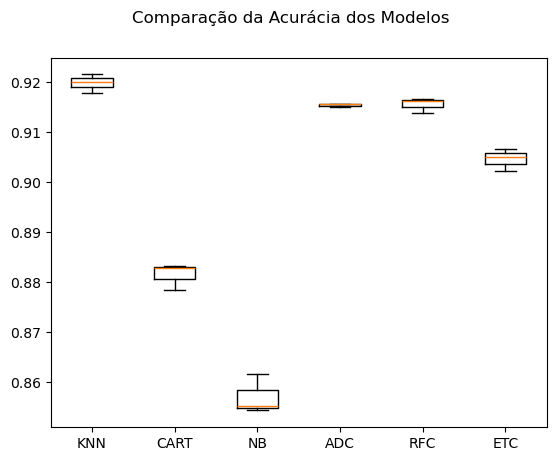

In [121]:
# Modelagem

# Definindo uma seed global para esta célula de código
np.random.seed(7)

# Listas para armazenar os modelos, os resultados e os nomes dos modelos
models = []
results = []
names = []

# Preparando os modelos e adicionando-os em uma lista
models.append(("KNN", KNeighborsClassifier()))
models.append(("CART", DecisionTreeClassifier()))
models.append(("NB", GaussianNB()))
# models.append(("SVM", SVC()))
models.append(("ADC", AdaBoostClassifier()))
models.append(("RFC", RandomForestClassifier()))
models.append(("ETC", ExtraTreesClassifier()))

# Avaliando um modelo por vez
# Aqui estão as métricas mais relevantes para essa área:
# Acurácia (Accuracy): A proporção de predições corretas sobre o total de predições.
# Precisão (Precision): Dos casos que o modelo previu como positivos, quantos eram realmente positivos.
# Sensibilidade (Recall): Dos casos que eram realmente positivos, quantos o modelo conseguiu identificar.
# Pontuação F1 (F1-Score): É a média harmônica entre precisão e recall. É uma métrica útil quando as classes estão desbalanceadas.
# Curva ROC e AUC: Medem a capacidade do modelo de distinguir entre as classes.
for name, model in models:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring="accuracy")
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (
        name,
        cv_results.mean(),
        cv_results.std(),
    )  # média e desvio padrão dos K resultados da validação cruzada
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure()
fig.suptitle("Comparação da Acurácia dos Modelos")
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()